## 读取数据

In [467]:
import pandas as pd
import numpy as np

In [468]:
# 读取安装数据即首次访问
def read_install(app_name, target_day):
    base_dir = 'sample-data/section9/snapshot/install'
    f = 'data/{}/{}/{}/install.csv'.format(base_dir, app_name, target_day)
    df = pd.read_csv(f)
    return df

In [469]:
# read_install('game-01', '2013-09-30')

In [470]:
# 读取DAU数据
def read_dau(app_name, date_from, date_to):
    base_dir = 'sample-data/section9/daily/dau'
    dt_from = pd.to_datetime(date_from)
    dt_to = pd.to_datetime(date_to)
    dates = [i.strftime('%Y-%m-%d') for i in pd.date_range(date_from, date_to, freq='d').to_list()]
    dfs = []

    for day in dates:
        f = 'data/{}/{}/{}/dau.csv'.format(base_dir, app_name, day)
        df = pd.read_csv(f)
        dfs.append(df)

    frame = pd.concat(dfs, ignore_index=True)
    return frame

In [471]:
# read_dau('game-01', '2013-06-01', '2013-09-30')

In [472]:
# 读取行为数据
def read_action(app_name, action_name, date_from, date_to):
    base_dir = 'sample-data/section9/daily/action'
    dt_from = pd.to_datetime(date_from)
    dt_to = pd.to_datetime(date_to)
    dates = [i.strftime('%Y-%m-%d') for i in pd.date_range(date_from, date_to, freq='d').to_list()]
    dfs = []

    for day in dates:
        f = 'data/{}/{}/{}/{}/{}.csv'.format(base_dir, app_name, action_name, day, action_name)
        df = pd.read_csv(f)
        dfs.append(df)

    frame = pd.concat(dfs, ignore_index=True)
    return frame

In [473]:
# read_action('game-01', 'battle', '2013-06-01', '2013-08-31')

In [474]:
# Install
install = read_install('game-01', '2013-09-30')

In [475]:
# DAU
dau = read_dau('game-01', '2013-06-01', '2013-09-30')

In [476]:
# 战斗
battle = read_action('game-01', 'battle', '2013-06-01', '2013-08-31')
# 发送消息
msg = read_action('game-01', 'message', '2013-06-01', '2013-08-31')
# 协作
hlp = read_action('game-01', 'help', '2013-06-01', '2013-08-31')

## 计算登录密度

In [477]:
# 合并DAU和首次访问数据 
dau_inst = pd.merge(dau, install, on='user_id', suffixes=('', '_inst'))

In [478]:
dau_inst.head()

,log_date,app_name,user_id,log_date_inst,install_time,gender,generation,device_type
0,2013-06-01,game-01,1701,2013-06-01,1370016924,F,30,Android
1,2013-06-02,game-01,1701,2013-06-01,1370016924,F,30,Android
2,2013-06-01,game-01,1720,2013-06-01,1370041323,M,20,Android
3,2013-06-02,game-01,1720,2013-06-01,1370041323,M,20,Android
4,2013-06-01,game-01,1087,2013-05-25,1369480705,F,10,Android


In [479]:
# 筛选用户为开始游戏后第7~13天的数据
dau_inst['log_date'] = pd.to_datetime(dau_inst['log_date'])
dau_inst['log_date_inst'] = pd.to_datetime(dau_inst['log_date_inst'])
dau_inst['elapsed_days'] = (dau_inst['log_date'] - dau_inst['log_date_inst']).dt.days
dau_inst_7_13 = dau_inst[(dau_inst['elapsed_days'] >= 7) & (dau_inst['elapsed_days'] <= 13)]

In [480]:
# 计算登录密度
dau_inst_7_13_login_ds = dau_inst_7_13.groupby('user_id').agg({'log_date': lambda x: len(x) / 7})
dau_inst_7_13_login_ds = dau_inst_7_13_login_ds.reset_index().rename(columns={'log_date': 'density'})

In [481]:
dau_inst_7_13_login_ds.head()

,user_id,density
0,301,0.142857
1,310,0.142857
2,316,0.142857
3,319,0.142857
4,322,0.142857


In [482]:
# 筛选目标用户
install['log_date'] = pd.to_datetime(install['log_date'])
target_install = install[(install['log_date'] >= '2013-06-01') & (install['log_date'] <= '2013-08-25')]

In [483]:
# 合并目标用户和登录密度数据
target_install_login_ds = pd.merge(target_install, dau_inst_7_13_login_ds, how='left', on='user_id')
target_install_login_ds['density'] = np.where(target_install_login_ds['density'].isnull(), 0, target_install_login_ds['density'])

In [484]:
target_install_login_ds.head()

,log_date,user_id,install_time,gender,generation,device_type,density
0,2013-06-01,1693,1370012721,F,20,Android,0.0
1,2013-06-01,1694,1370013166,F,20,Android,0.0
2,2013-06-01,1695,1370013609,M,40,Android,0.0
3,2013-06-01,1696,1370014074,M,20,Android,0.0
4,2013-06-01,1697,1370014654,F,30,iOS,0.0


## 生成关于战斗的数据

In [485]:
# 合并战斗行为数据和用户首次访问时间的数据
battle_inst = pd.merge(battle, install, on='user_id', suffixes=('', '_inst'))

In [486]:
battle_inst.head()

,log_date,app_name,action_name,user_id,count,log_date_inst,install_time,gender,generation,device_type
0,2013-06-01,game-01,battle,1087,1,2013-05-25,1369480705,F,10,Android
1,2013-06-07,game-01,battle,1087,1,2013-05-25,1369480705,F,10,Android
2,2013-06-01,game-01,battle,1570,1,2013-05-30,1369868885,M,50,iOS
3,2013-06-01,game-01,battle,1570,1,2013-05-30,1369868885,M,50,iOS
4,2013-06-01,game-01,battle,1257,1,2013-05-26,1369563585,F,10,iOS


In [487]:
# 计算用户进行战斗的时间和首次访问时间的时间差
battle_inst['log_date'] = pd.to_datetime(battle_inst['log_date'])
battle_inst['log_date_inst'] = pd.to_datetime(battle_inst['log_date_inst'])
battle_inst['elapsed_days'] = (battle_inst['log_date'] - battle_inst['log_date_inst']).dt.days

In [488]:
# 筛选用户进行战斗的时间和首次访问时间的时间差在1周以内的数据
battle_inst2 = battle_inst[(battle_inst['elapsed_days'] >= 0) & (battle_inst['elapsed_days'] <= 6)].copy()

In [489]:
battle_inst2.head()

,log_date,app_name,action_name,user_id,count,log_date_inst,install_time,gender,generation,device_type,elapsed_days
2,2013-06-01,game-01,battle,1570,1,2013-05-30,1369868885,M,50,iOS,2
3,2013-06-01,game-01,battle,1570,1,2013-05-30,1369868885,M,50,iOS,2
4,2013-06-01,game-01,battle,1257,1,2013-05-26,1369563585,F,10,iOS,6
5,2013-06-01,game-01,battle,1257,1,2013-05-26,1369563585,F,10,iOS,6
6,2013-06-01,game-01,battle,1257,1,2013-05-26,1369563585,F,10,iOS,6


In [490]:
# battle_inst2['elapsed_days'] = battle_inst2['elapsed_days'].map(lambda x: 'd' + str(x))

In [491]:
# 将首次访问之后经过的天数按列交叉
battle_inst2_cast = battle_inst2.pivot_table(index='user_id', columns='elapsed_days', values='count', aggfunc='sum').fillna(0)
battle_inst2_cast.columns = battle_inst2_cast.columns.map(lambda x: 'd'+str(x))

In [492]:
battle_inst2_cast.head(6)

elapsed_days,d0,d1,d2,d3,d4,d5,d6
user_id,,,,,,,
1257,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1269,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1295,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1512,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1570,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1611,0.0,0.0,1.0,7.0,0.0,0.0,0.0


In [493]:
# 生成比率数据
battle_inst2_cast_prop = battle_inst2_cast.copy()
battle_inst2_cast_prop = battle_inst2_cast_prop.apply(lambda x: x / battle_inst2_cast_prop.sum(axis=1))

In [494]:
battle_inst2_cast_prop.head(6)

elapsed_days,d0,d1,d2,d3,d4,d5,d6
user_id,,,,,,,
1257,0.0,0.0,0.000,0.000,0.0,0.0,1.0
1269,0.0,0.0,0.000,0.000,0.0,0.0,1.0
1295,0.0,0.0,0.000,0.000,0.0,0.0,1.0
1512,0.0,0.0,0.000,0.000,1.0,0.0,0.0
1570,0.0,0.0,1.000,0.000,0.0,0.0,0.0
1611,0.0,0.0,0.125,0.875,0.0,0.0,0.0


In [495]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [496]:
# PCA
X = battle_inst2_cast_prop.values
# X = scale(X)
b_pca = PCA(whiten=True) 
b_pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [497]:
b_pca_x = b_pca.transform(X)

In [498]:
pca_names = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']

In [499]:
battle_inst2_cast_pca = pd.DataFrame(b_pca_x, index=battle_inst2_cast_prop.index, columns=pca_names)

In [500]:
battle_inst2_cast_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
user_id,,,,,,,
1257,-0.581643,-1.585501,2.536447,-0.608569,-0.950349,-0.839215,0.899820
1269,-0.581643,-1.585501,2.536447,-0.608569,-0.950349,-0.839215,0.899820
1295,-0.581643,-1.585501,2.536447,-0.608569,-0.950349,-0.839215,0.899820
1512,-0.466431,-1.259834,-1.518763,2.673706,-1.666656,-0.602162,1.886831
1570,-0.525947,-0.928365,-2.196892,-2.547445,-0.242870,-0.845898,-0.630990


## 生成发送消息的数据

In [501]:
# 合并发送消息数据和用户首次访问时间的数据
msg_inst = pd.merge(msg, install, on='user_id', suffixes=('', '_inst'))

In [502]:
msg_inst.head()

,log_date,app_name,action_name,user_id,count,log_date_inst,install_time,gender,generation,device_type
0,2013-06-01,game-01,message,8,8,2013-05-14,1368534088,M,20,Android
1,2013-06-02,game-01,message,8,2,2013-05-14,1368534088,M,20,Android
2,2013-06-07,game-01,message,8,2,2013-05-14,1368534088,M,20,Android
3,2013-06-15,game-01,message,8,2,2013-05-14,1368534088,M,20,Android
4,2013-06-01,game-01,message,13,10,2013-05-15,1368548335,M,10,Android


In [503]:
# 计算发送消息的时间和首次访问时间的时间差
msg_inst['log_date'] = pd.to_datetime(msg_inst['log_date'])
msg_inst['log_date_inst'] = pd.to_datetime(msg_inst['log_date_inst'])
msg_inst['elapsed_days'] = (msg_inst['log_date'] - msg_inst['log_date_inst']).dt.days

In [504]:
# 筛选发送消息的时间和首次访问时间的时间差在1周以内的数据
msg_inst2 = msg_inst[(msg_inst['elapsed_days'] >= 0) & (msg_inst['elapsed_days'] <= 6)].copy()

In [505]:
# 将首次访问之后经过的天数按列交叉
msg_inst2_cast = msg_inst2.pivot_table(index='user_id', columns='elapsed_days', values='count', aggfunc='sum').fillna(0)
msg_inst2_cast.columns = msg_inst2_cast.columns.map(lambda x: 'd'+str(x))

In [506]:
msg_inst2_cast.head()

elapsed_days,d0,d1,d2,d3,d4,d5,d6
user_id,,,,,,,
1136,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1158,0.0,0.0,0.0,0.0,0.0,0.0,10.0
1160,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1164,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1165,0.0,0.0,0.0,0.0,0.0,0.0,10.0


In [507]:
# 生成比率数据
msg_inst2_cast_prop = msg_inst2_cast.copy()
msg_inst2_cast_prop = msg_inst2_cast_prop.apply(lambda x: x / msg_inst2_cast_prop.sum(axis=1))

In [508]:
msg_inst2_cast_prop.head()

elapsed_days,d0,d1,d2,d3,d4,d5,d6
user_id,,,,,,,
1136,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1158,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1160,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1164,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1165,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [509]:
# PCA
X = msg_inst2_cast_prop.values
# X = scale(X)
m_pca = PCA(whiten=True)
m_pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [510]:
m_pca_x = m_pca.transform(X)

In [511]:
msg_inst2_cast_pca = pd.DataFrame(m_pca_x, index=msg_inst2_cast_prop.index, columns=pca_names)

In [512]:
msg_inst2_cast_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
user_id,,,,,,,
1136,2.065516,-3.026717,4.984398,-2.997592,0.589555,-0.282227,0.626694
1158,2.065516,-3.026717,4.984398,-2.997592,0.589555,-0.282227,0.626694
1160,2.065516,-3.026717,4.984398,-2.997592,0.589555,-0.282227,0.626694
1164,2.065516,-3.026717,4.984398,-2.997592,0.589555,-0.282227,0.626694
1165,2.065516,-3.026717,4.984398,-2.997592,0.589555,-0.282227,0.626694


## 生成协作数据

In [513]:
# 合并用户协作数据和首次访问时间的数据
hlp_inst = pd.merge(hlp, install, on='user_id', suffixes=('', '_inst'))

In [514]:
hlp_inst.head()

,log_date,app_name,action_name,user_id,count,log_date_inst,install_time,gender,generation,device_type
0,2013-06-01,game-01,help,6,3,2013-05-14,1368527040,F,10,iOS
1,2013-06-01,game-01,help,8,13,2013-05-14,1368534088,M,20,Android
2,2013-06-02,game-01,help,8,7,2013-05-14,1368534088,M,20,Android
3,2013-06-04,game-01,help,8,7,2013-05-14,1368534088,M,20,Android
4,2013-06-05,game-01,help,8,3,2013-05-14,1368534088,M,20,Android


In [515]:
# 计算发生协作的时间和首次访问时间的时间差
hlp_inst['log_date'] = pd.to_datetime(hlp_inst['log_date'])
hlp_inst['log_date_inst'] = pd.to_datetime(hlp_inst['log_date_inst'])
hlp_inst['elapsed_days'] = (hlp_inst['log_date'] - hlp_inst['log_date_inst']).dt.days

In [516]:
# 筛选发生协作的时间和首次访问时间的时间差在1周以内的数据
hlp_inst2 = hlp_inst[(hlp_inst['elapsed_days'] >= 0) & (hlp_inst['elapsed_days'] <= 6)].copy()

In [517]:
# 将首次访问之后经过的天数按列排列
hlp_inst2_cast = hlp_inst2.pivot_table(index='user_id', columns='elapsed_days', values='count', aggfunc='sum').fillna(0)
hlp_inst2_cast.columns = hlp_inst2_cast.columns.map(lambda x: 'd'+str(x))

In [518]:
hlp_inst2_cast.head()

elapsed_days,d0,d1,d2,d3,d4,d5,d6
user_id,,,,,,,
1136,0.0,0.0,0.0,0.0,0.0,0.0,14.0
1148,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1158,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1160,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1164,0.0,0.0,0.0,0.0,0.0,0.0,8.0


In [519]:
# 生成比率数据
hlp_inst2_cast_prop = hlp_inst2_cast.copy()
hlp_inst2_cast_prop = hlp_inst2_cast_prop.apply(lambda x: x / hlp_inst2_cast_prop.sum(axis=1))

In [520]:
# PCA
X = hlp_inst2_cast_prop.values
# X = scale(X)
h_pca = PCA(whiten=True)
h_pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [521]:
h_pca_x = h_pca.transform(X)

In [522]:
hlp_inst2_cast_pca = pd.DataFrame(h_pca_x, index=hlp_inst2_cast_prop.index, columns=pca_names)

In [523]:
hlp_inst2_cast_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
user_id,,,,,,,
1136,1.175555,-2.189802,3.268973,0.893467,0.160419,-0.185185,0.817597
1148,1.175555,-2.189802,3.268973,0.893467,0.160419,-0.185185,0.817597
1158,1.175555,-2.189802,3.268973,0.893467,0.160419,-0.185185,0.817597
1160,1.175555,-2.189802,3.268973,0.893467,0.160419,-0.185185,0.817597
1164,1.175555,-2.189802,3.268973,0.893467,0.160419,-0.185185,0.817597


## 对行为日志进行聚类

In [524]:
from sklearn.cluster import KMeans

In [525]:
# 生成聚类数据函数
def create_cluster_data(aname, x, x_prop, x_pca):
    dfs = []
    for i in range(3, 7):
        km = KMeans(n_clusters=i, random_state=10)
        km.fit(x)
        km_prop = KMeans(n_clusters=i, random_state=10)
        km_prop.fit(x_prop)
        km_pca = KMeans(n_clusters=i, random_state=10)
        km_pca.fit(x_pca)
        sub = pd.DataFrame({'user_id': x.index, 'cluster_type': '{}{:0>2d}'.format(aname, i), 'freq_cluster_id': km.labels_,
                           'prop_cluster_id': km_prop.labels_, 'pca_cluster_id': km_pca.labels_})
        dfs.append(sub)
        
    df = pd.concat(dfs)
    cluster_melt = pd.melt(df, id_vars=['user_id', 'cluster_type'])
    result = cluster_melt.pivot_table(index='user_id', columns=['cluster_type', 'variable'], values='value', aggfunc='sum')
    result.columns = ['{}_{}'.format(i, j) for i,j in result.columns]
    return result

In [526]:
# 战斗
battle_cluster = create_cluster_data('battle', battle_inst2_cast, battle_inst2_cast_prop, battle_inst2_cast_pca)

In [527]:
battle_cluster.head()

,battle03_freq_cluster_id,battle03_pca_cluster_id,battle03_prop_cluster_id,battle04_freq_cluster_id,battle04_pca_cluster_id,battle04_prop_cluster_id,battle05_freq_cluster_id,battle05_pca_cluster_id,battle05_prop_cluster_id,battle06_freq_cluster_id,battle06_pca_cluster_id,battle06_prop_cluster_id
user_id,,,,,,,,,,,,
1257,0,2,1,3,2,0,2,2,1,2,0,3
1269,0,2,1,3,2,0,2,2,1,2,0,3
1295,0,2,1,3,2,0,2,2,1,2,0,3
1512,2,1,1,0,3,3,0,4,3,0,4,0
1570,2,0,1,0,0,3,0,0,2,0,2,2


In [528]:
# 发送消息
msg_cluster = create_cluster_data('msg', msg_inst2_cast, msg_inst2_cast_prop, msg_inst2_cast_pca)

In [529]:
msg_cluster.head()

,msg03_freq_cluster_id,msg03_pca_cluster_id,msg03_prop_cluster_id,msg04_freq_cluster_id,msg04_pca_cluster_id,msg04_prop_cluster_id,msg05_freq_cluster_id,msg05_pca_cluster_id,msg05_prop_cluster_id,msg06_freq_cluster_id,msg06_pca_cluster_id,msg06_prop_cluster_id
user_id,,,,,,,,,,,,
1136,0,0,2,0,3,2,1,2,2,0,3,2
1158,0,0,2,0,3,2,1,2,2,0,3,2
1160,0,0,2,0,3,2,1,2,2,0,3,2
1164,0,0,2,0,3,2,1,2,2,0,3,2
1165,0,0,2,0,3,2,1,2,2,0,3,2


In [530]:
# 协作
hlp_cluster = create_cluster_data('hlp', hlp_inst2_cast, hlp_inst2_cast_prop, hlp_inst2_cast_pca)

In [568]:
hlp_cluster.head()

,hlp03_freq_cluster_id,hlp03_pca_cluster_id,hlp03_prop_cluster_id,hlp04_freq_cluster_id,hlp04_pca_cluster_id,hlp04_prop_cluster_id,hlp05_freq_cluster_id,hlp05_pca_cluster_id,hlp05_prop_cluster_id,hlp06_freq_cluster_id,hlp06_pca_cluster_id,hlp06_prop_cluster_id
user_id,,,,,,,,,,,,
1136,0,1,1,0,2,2,0,3,3,0,1,3
1148,0,1,1,0,2,2,0,3,3,0,1,3
1158,0,1,1,0,2,2,0,3,3,0,1,3
1160,0,1,1,0,2,2,0,3,3,0,1,3
1164,0,1,1,0,2,2,0,3,3,0,1,3


## 类合并

In [532]:
cluster_data = pd.merge(target_install_login_ds, battle_cluster.reset_index(), on='user_id', how='left')

In [533]:
cluster_data = pd.merge(cluster_data, msg_cluster.reset_index(), on='user_id', how='left')

In [534]:
cluster_data = pd.merge(cluster_data, hlp_cluster.reset_index(), on='user_id', how='left')

In [535]:
cluster_data = cluster_data.fillna(0)

In [536]:
cluster_data.head()

,log_date,user_id,install_time,gender,generation,device_type,density,battle03_freq_cluster_id,battle03_pca_cluster_id,battle03_prop_cluster_id,...,hlp03_prop_cluster_id,hlp04_freq_cluster_id,hlp04_pca_cluster_id,hlp04_prop_cluster_id,hlp05_freq_cluster_id,hlp05_pca_cluster_id,hlp05_prop_cluster_id,hlp06_freq_cluster_id,hlp06_pca_cluster_id,hlp06_prop_cluster_id
0,2013-06-01,1693,1370012721,F,20,Android,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-06-01,1694,1370013166,F,20,Android,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0
2,2013-06-01,1695,1370013609,M,40,Android,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-06-01,1696,1370014074,M,20,Android,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-06-01,1697,1370014654,F,30,iOS,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [537]:
# cluster_data.sum()

## 按照登录密度重新排列

In [538]:
# 将列转换为行
cluster_data_melt = pd.melt(cluster_data.set_index('user_id').loc[:, 'density':].reset_index(), id_vars=['user_id', 'density'])

In [539]:
cluster_data_melt.head()

,user_id,density,variable,value
0,1693,0.0,battle03_freq_cluster_id,0.0
1,1694,0.0,battle03_freq_cluster_id,0.0
2,1695,0.0,battle03_freq_cluster_id,0.0
3,1696,0.0,battle03_freq_cluster_id,0.0
4,1697,0.0,battle03_freq_cluster_id,0.0


In [540]:
# 按照类的种类或编号计算各个类的平均登录密度
cluster_data_avg = cluster_data_melt.groupby(['variable', 'value']).agg({'density': 'mean'}).reset_index()
cluster_data_avg = cluster_data_avg.rename(columns={'density': 'average_density'})

In [541]:
# cluster_data_

In [542]:
cluster_data_avg.head()

,variable,value,average_density
0,battle03_freq_cluster_id,0.0,0.070574
1,battle03_freq_cluster_id,1.0,1.000000
2,battle03_freq_cluster_id,2.0,0.465986
3,battle03_pca_cluster_id,0.0,0.072544
4,battle03_pca_cluster_id,1.0,0.542857


In [543]:
cluster_data_avg = cluster_data_avg.sort_values(['variable', 'average_density'])

In [544]:
cluster_data_avg['value2'] = cluster_data_avg.groupby(['variable'])['average_density'].apply(lambda x: x.rank())

In [545]:
cluster_data_avg.head(10)

,variable,value,average_density,value2
0,battle03_freq_cluster_id,0.0,0.070574,1.0
2,battle03_freq_cluster_id,2.0,0.465986,2.0
1,battle03_freq_cluster_id,1.0,1.000000,3.0
3,battle03_pca_cluster_id,0.0,0.072544,1.0
4,battle03_pca_cluster_id,1.0,0.542857,2.0
5,battle03_pca_cluster_id,2.0,0.734694,3.0
6,battle03_prop_cluster_id,0.0,0.070066,1.0
8,battle03_prop_cluster_id,2.0,0.551020,2.0
7,battle03_prop_cluster_id,1.0,0.753968,3.0
9,battle04_freq_cluster_id,0.0,0.074448,1.0


In [546]:
cluster_data_melt2 = pd.merge(cluster_data_melt, cluster_data_avg, on=['variable', 'value'])

In [547]:
# cluster_data_melt2[cluster_data_melt2['user_id'] == 1693]

In [548]:
cluster_data_melt2.head()

,user_id,density,variable,value,average_density,value2
0,1693,0.0,battle03_freq_cluster_id,0.0,0.070574,1.0
1,1694,0.0,battle03_freq_cluster_id,0.0,0.070574,1.0
2,1695,0.0,battle03_freq_cluster_id,0.0,0.070574,1.0
3,1696,0.0,battle03_freq_cluster_id,0.0,0.070574,1.0
4,1697,0.0,battle03_freq_cluster_id,0.0,0.070574,1.0


In [549]:
cluster_data_melt2.value2.value_counts()

1.0    93643
2.0     8494
3.0     1851
4.0     1195
5.0      942
6.0      712
3.5       11
Name: value2, dtype: int64

In [550]:
# cluster_data_melt2[cluster_data_melt2['user_id'] == 1693]

In [551]:
cluster_data2 = cluster_data_melt2.pivot_table(index=['user_id', 'density'], columns='variable', values='value2', aggfunc='sum')

In [552]:
cluster_data2.head(10)

,variable,battle03_freq_cluster_id,battle03_pca_cluster_id,battle03_prop_cluster_id,battle04_freq_cluster_id,battle04_pca_cluster_id,battle04_prop_cluster_id,battle05_freq_cluster_id,battle05_pca_cluster_id,battle05_prop_cluster_id,battle06_freq_cluster_id,...,msg03_prop_cluster_id,msg04_freq_cluster_id,msg04_pca_cluster_id,msg04_prop_cluster_id,msg05_freq_cluster_id,msg05_pca_cluster_id,msg05_prop_cluster_id,msg06_freq_cluster_id,msg06_pca_cluster_id,msg06_prop_cluster_id
user_id,density,,,,,,,,,,,,,,,,,,,,,
1693,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
1694,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
1695,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
1696,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
1697,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
1698,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
1699,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
1700,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
1701,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0


In [553]:
# for i in cluster_data2.columns:
#     print(cluster_data2[i].value_counts())

In [554]:
cluster_data3 = cluster_data_melt2[cluster_data_melt2['variable'] == 'hlp04_pca_cluster_id'][['user_id', 'average_density', 'value2']]

In [555]:
cluster_data3 = cluster_data3.rename(columns={'value2': 'cluster'})

In [556]:
cluster_data3.head()

,user_id,average_density,cluster
83104,1693,0.022266,1.0
83105,1694,0.022266,1.0
83106,1695,0.022266,1.0
83107,1696,0.022266,1.0
83108,1697,0.022266,1.0


In [557]:
hlp_inst2_cast_prop2 = pd.merge(hlp_inst2_cast_prop, cluster_data3, on='user_id')

In [558]:
hlp_inst2_cast_prop2['cluster'].value_counts()

4.0    306
1.0    275
2.0     57
3.0     13
Name: cluster, dtype: int64

In [559]:
hlp_inst2_cast_prop2.head()

,user_id,d0,d1,d2,d3,d4,d5,d6,average_density,cluster
0,1694,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022266,1.0
1,1711,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.479925,4.0
2,1717,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022266,1.0
3,1726,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022266,1.0
4,1748,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022266,1.0


In [560]:
hlp_inst2_cast_prop2.isnull().sum()

user_id            0
d0                 0
d1                 0
d2                 0
d3                 0
d4                 0
d5                 0
d6                 0
average_density    0
cluster            0
dtype: int64

In [561]:
def dx_value(x):
    return sum(x) / len(x)

In [570]:
hlp_inst2_cast_summary = hlp_inst2_cast_prop2.groupby('cluster').agg({'average_density': 'mean', 'user_id': 'count', 'd0': dx_value,
                                                                     'd1': dx_value, 'd2': dx_value, 'd3': dx_value,
                                                                     'd4': dx_value, 'd5': dx_value, 'd6': dx_value})

In [571]:
hlp_inst2_cast_summary = hlp_inst2_cast_summary.reset_index().rename(columns={'average_density': 'login_density'})

In [572]:
hlp_inst2_cast_summary.head()

,cluster,login_density,user_id,d0,d1,d2,d3,d4,d5,d6
0,1.0,0.022266,275,0.961532,0.019684,0.004764,0.004680,0.003189,0.001672,0.004478
1,2.0,0.308271,57,0.166255,0.101810,0.563144,0.052818,0.034178,0.046327,0.035467
2,3.0,0.373626,13,0.129957,0.022575,0.000000,0.000000,0.000000,0.032051,0.815416
3,4.0,0.479925,306,0.205927,0.299489,0.080452,0.122316,0.118810,0.106641,0.066364


In [565]:
import matplotlib.pyplot as plt

In [566]:
%matplotlib inline

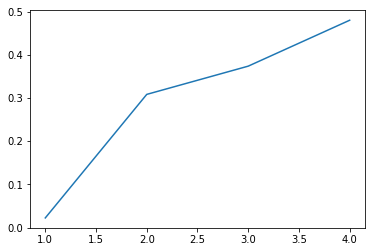

In [567]:
plt.plot(hlp_inst2_cast_summary['cluster'], hlp_inst2_cast_summary['login_density'])